<a href="https://colab.research.google.com/github/SihaAma/Medical_image_segmentaion/blob/main/Spleen_3D_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Spleen dataset can be downloaded from http://medicaldecathlon.com/.


In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib
!pip install -q pytorch-lightning==1.4.0
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 718 kB 5.5 MB/s 
     |████████████████████████████████| 913 kB 5.4 MB/s 
     |████████████████████████████████| 596 kB 41.6 MB/s 
     |████████████████████████████████| 332 kB 50.5 MB/s 
     |████████████████████████████████| 829 kB 43.0 MB/s 
     |████████████████████████████████| 132 kB 51.6 MB/s 
     |████████████████████████████████| 1.1 MB 45.4 MB/s 
     |████████████████████████████████| 192 kB 50.1 MB/s 
     |████████████████████████████████| 271 kB 53.7 MB/s 
     |████████████████████████████████| 160 kB 44.5 MB/s 


In [2]:
from monai.utils import set_determinism
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, list_data_collate, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import pytorch_lightning
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

MONAI version: 0.9.dev2152
Numpy version: 1.19.5
Pytorch version: 1.10.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: c5bd8aff8ba461d7b349eb92427d452481a7eb72

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.7.0
gdown version: 3.6.4
TorchVision version: 0.11.1+cu111
tqdm version: 4.62.3
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
import os
os.chdir('/content/drive/MyDrive/Githubproject/3D_Segmenation')

In [4]:
directory = "/content/drive/My Drive/Githubproject/3D_Segmenation/DATA_DIRECTORY"
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/content/drive/My Drive/Githubproject/3D_Segmenation/DATA_DIRECTORY


In [5]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

In [6]:
class Net(pytorch_lightning.LightningModule):
    def __init__(self):
        super().__init__()
        self._model = UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=2,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
            norm=Norm.BATCH,
        )
        self.loss_function = DiceLoss(to_onehot_y=True, softmax=True)
        self.post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
        self.post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])
        self.dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
        self.best_val_dice = 0
        self.best_val_epoch = 0

    def forward(self, x):
        return self._model(x)

    def prepare_data(self):
        # set up the correct data path
        train_images = sorted(
            glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
        train_labels = sorted(
            glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
        data_dicts = [
            {"image": image_name, "label": label_name}
            for image_name, label_name in zip(train_images, train_labels)
        ]
        train_files, val_files = data_dicts[:-9], data_dicts[-9:]

        # set deterministic training for reproducibility
        set_determinism(seed=0)

        # define the data transforms
        train_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                AddChanneld(keys=["image", "label"]),
                Spacingd(
                    keys=["image", "label"],
                    pixdim=(1.5, 1.5, 2.0),
                    mode=("bilinear", "nearest"),
                ),
                Orientationd(keys=["image", "label"], axcodes="RAS"),
                ScaleIntensityRanged(
                    keys=["image"], a_min=-57, a_max=164,
                    b_min=0.0, b_max=1.0, clip=True,
                ),
                CropForegroundd(keys=["image", "label"], source_key="image"),
                # randomly crop out patch samples from
                # big image based on pos / neg ratio
                # the image centers of negative samples
                # must be in valid image area
                RandCropByPosNegLabeld(
                    keys=["image", "label"],
                    label_key="label",
                    spatial_size=(96, 96, 96),
                    pos=1,
                    neg=1,
                    num_samples=4,
                    image_key="image",
                    image_threshold=0,
                ),
                # user can also add other random transforms
                #                 RandAffined(
                #                     keys=['image', 'label'],
                #                     mode=('bilinear', 'nearest'),
                #                     prob=1.0,
                #                     spatial_size=(96, 96, 96),
                #                     rotate_range=(0, 0, np.pi/15),
                #                     scale_range=(0.1, 0.1, 0.1)),
                EnsureTyped(keys=["image", "label"]),
            ]
        )
        val_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                AddChanneld(keys=["image", "label"]),
                Spacingd(
                    keys=["image", "label"],
                    pixdim=(1.5, 1.5, 2.0),
                    mode=("bilinear", "nearest"),
                ),
                Orientationd(keys=["image", "label"], axcodes="RAS"),
                ScaleIntensityRanged(
                    keys=["image"], a_min=-57, a_max=164,
                    b_min=0.0, b_max=1.0, clip=True,
                ),
                CropForegroundd(keys=["image", "label"], source_key="image"),
                EnsureTyped(keys=["image", "label"]),
            ]
        )

        # we use cached datasets - these are 10x faster than regular datasets
        self.train_ds = CacheDataset(
            data=train_files, transform=train_transforms,
            cache_rate=1.0, num_workers=4,
        )
        self.val_ds = CacheDataset(
            data=val_files, transform=val_transforms,
            cache_rate=1.0, num_workers=4,
        )
#         self.train_ds = monai.data.Dataset(
#             data=train_files, transform=train_transforms)
#         self.val_ds = monai.data.Dataset(
#             data=val_files, transform=val_transforms)

    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(
            self.train_ds, batch_size=2, shuffle=True,
            num_workers=2, collate_fn=list_data_collate,
        )
        return train_loader

    def val_dataloader(self):
        val_loader = torch.utils.data.DataLoader(
            self.val_ds, batch_size=1, num_workers=2)
        return val_loader

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self._model.parameters(), 1e-4)
        return optimizer

    def training_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        tensorboard_logs = {"train_loss": loss.item()}
        return {"loss": loss, "log": tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        outputs = sliding_window_inference(
            images, roi_size, sw_batch_size, self.forward)
        loss = self.loss_function(outputs, labels)
        outputs = [self.post_pred(i) for i in decollate_batch(outputs)]
        labels = [self.post_label(i) for i in decollate_batch(labels)]
        self.dice_metric(y_pred=outputs, y=labels)
        return {"val_loss": loss, "val_number": len(outputs)}

    def validation_epoch_end(self, outputs):
        val_loss, num_items = 0, 0
        for output in outputs:
            val_loss += output["val_loss"].sum().item()
            num_items += output["val_number"]
        mean_val_dice = self.dice_metric.aggregate().item()
        self.dice_metric.reset()
        mean_val_loss = torch.tensor(val_loss / num_items)
        tensorboard_logs = {
            "val_dice": mean_val_dice,
            "val_loss": mean_val_loss,
        }
        if mean_val_dice > self.best_val_dice:
            self.best_val_dice = mean_val_dice
            self.best_val_epoch = self.current_epoch
        print(
            f"current epoch: {self.current_epoch} "
            f"current mean dice: {mean_val_dice:.4f}"
            f"\nbest mean dice: {self.best_val_dice:.4f} "
            f"at epoch: {self.best_val_epoch}"
        )
        return {"log": tensorboard_logs}

In [7]:
# initialise the LightningModule
net = Net()

# set up loggers and checkpoints
log_dir = os.path.join(root_dir, "logs")
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(
    save_dir=log_dir
)

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus=[0],
    max_epochs=600,
    logger=tb_logger,
    checkpoint_callback=True,
    num_sanity_val_steps=1,
)

# train
trainer.fit(net)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Loading dataset: 100%|██████████| 9/9 [00:24<00:00,  2.74s/it]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type     | Params
-------------------------------------------
0 | _model        | UNet     | 4.8 M 
1 | loss_function | DiceLoss | 0     
-------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.236    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

current epoch: 0 current mean dice: 0.0085
best mean dice: 0.0085 at epoch: 0


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:323: UserWarning: The number of training samples (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

current epoch: 0 current mean dice: 0.0225
best mean dice: 0.0225 at epoch: 0


Validating: 0it [00:00, ?it/s]

current epoch: 1 current mean dice: 0.0295
best mean dice: 0.0295 at epoch: 1


Validating: 0it [00:00, ?it/s]

current epoch: 2 current mean dice: 0.0374
best mean dice: 0.0374 at epoch: 2


Validating: 0it [00:00, ?it/s]

current epoch: 3 current mean dice: 0.0442
best mean dice: 0.0442 at epoch: 3


Validating: 0it [00:00, ?it/s]

current epoch: 4 current mean dice: 0.0539
best mean dice: 0.0539 at epoch: 4


Validating: 0it [00:00, ?it/s]

current epoch: 5 current mean dice: 0.0585
best mean dice: 0.0585 at epoch: 5


Validating: 0it [00:00, ?it/s]

current epoch: 6 current mean dice: 0.0630
best mean dice: 0.0630 at epoch: 6


Validating: 0it [00:00, ?it/s]

current epoch: 7 current mean dice: 0.0675
best mean dice: 0.0675 at epoch: 7


Validating: 0it [00:00, ?it/s]

current epoch: 8 current mean dice: 0.0702
best mean dice: 0.0702 at epoch: 8


Validating: 0it [00:00, ?it/s]

current epoch: 9 current mean dice: 0.0656
best mean dice: 0.0702 at epoch: 8


Validating: 0it [00:00, ?it/s]

current epoch: 10 current mean dice: 0.0726
best mean dice: 0.0726 at epoch: 10


Validating: 0it [00:00, ?it/s]

current epoch: 11 current mean dice: 0.0663
best mean dice: 0.0726 at epoch: 10


Validating: 0it [00:00, ?it/s]

current epoch: 12 current mean dice: 0.0789
best mean dice: 0.0789 at epoch: 12


Validating: 0it [00:00, ?it/s]

current epoch: 13 current mean dice: 0.0788
best mean dice: 0.0789 at epoch: 12


Validating: 0it [00:00, ?it/s]

current epoch: 14 current mean dice: 0.0788
best mean dice: 0.0789 at epoch: 12


Validating: 0it [00:00, ?it/s]

current epoch: 15 current mean dice: 0.0746
best mean dice: 0.0789 at epoch: 12


Validating: 0it [00:00, ?it/s]

current epoch: 16 current mean dice: 0.0739
best mean dice: 0.0789 at epoch: 12


Validating: 0it [00:00, ?it/s]

current epoch: 17 current mean dice: 0.0764
best mean dice: 0.0789 at epoch: 12


Validating: 0it [00:00, ?it/s]

current epoch: 18 current mean dice: 0.0733
best mean dice: 0.0789 at epoch: 12


Validating: 0it [00:00, ?it/s]

current epoch: 19 current mean dice: 0.0664
best mean dice: 0.0789 at epoch: 12


Validating: 0it [00:00, ?it/s]

current epoch: 20 current mean dice: 0.0679
best mean dice: 0.0789 at epoch: 12


Validating: 0it [00:00, ?it/s]

current epoch: 21 current mean dice: 0.0495
best mean dice: 0.0789 at epoch: 12


Validating: 0it [00:00, ?it/s]

current epoch: 22 current mean dice: 0.0772
best mean dice: 0.0789 at epoch: 12


Validating: 0it [00:00, ?it/s]

current epoch: 23 current mean dice: 0.0799
best mean dice: 0.0799 at epoch: 23


Validating: 0it [00:00, ?it/s]

current epoch: 24 current mean dice: 0.0898
best mean dice: 0.0898 at epoch: 24


Validating: 0it [00:00, ?it/s]

current epoch: 25 current mean dice: 0.0669
best mean dice: 0.0898 at epoch: 24


Validating: 0it [00:00, ?it/s]

current epoch: 26 current mean dice: 0.1248
best mean dice: 0.1248 at epoch: 26


Validating: 0it [00:00, ?it/s]

current epoch: 27 current mean dice: 0.0843
best mean dice: 0.1248 at epoch: 26


Validating: 0it [00:00, ?it/s]

current epoch: 28 current mean dice: 0.0902
best mean dice: 0.1248 at epoch: 26


Validating: 0it [00:00, ?it/s]

current epoch: 29 current mean dice: 0.0665
best mean dice: 0.1248 at epoch: 26


Validating: 0it [00:00, ?it/s]

current epoch: 30 current mean dice: 0.0642
best mean dice: 0.1248 at epoch: 26


Validating: 0it [00:00, ?it/s]

current epoch: 31 current mean dice: 0.0746
best mean dice: 0.1248 at epoch: 26


Validating: 0it [00:00, ?it/s]

current epoch: 32 current mean dice: 0.0863
best mean dice: 0.1248 at epoch: 26


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1047: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [8]:
print(
f"train completed, best_metric: {net.best_val_dice:.4f} "
f"at epoch {net.best_val_epoch}")

train completed, best_metric: 0.1248 at epoch 26


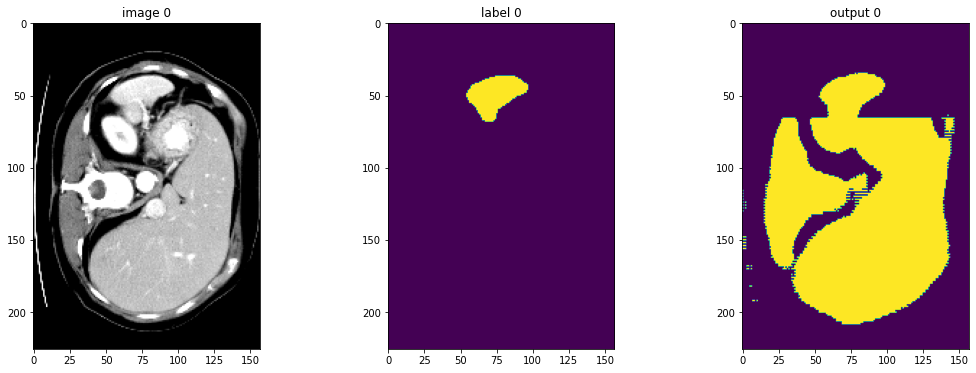

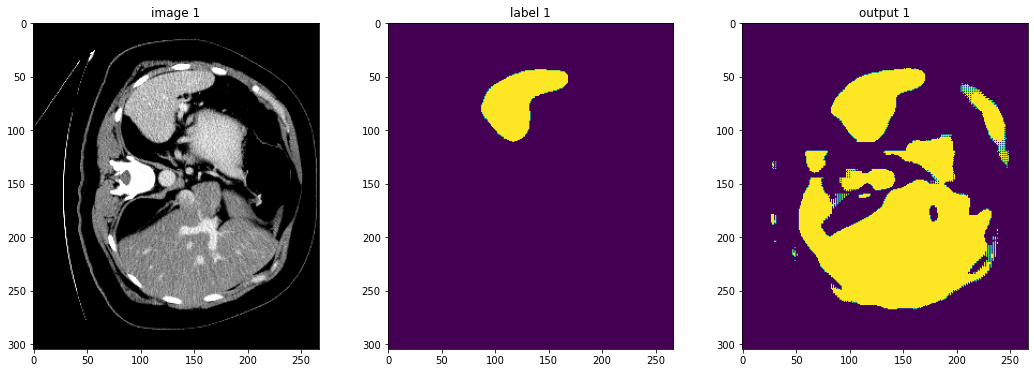

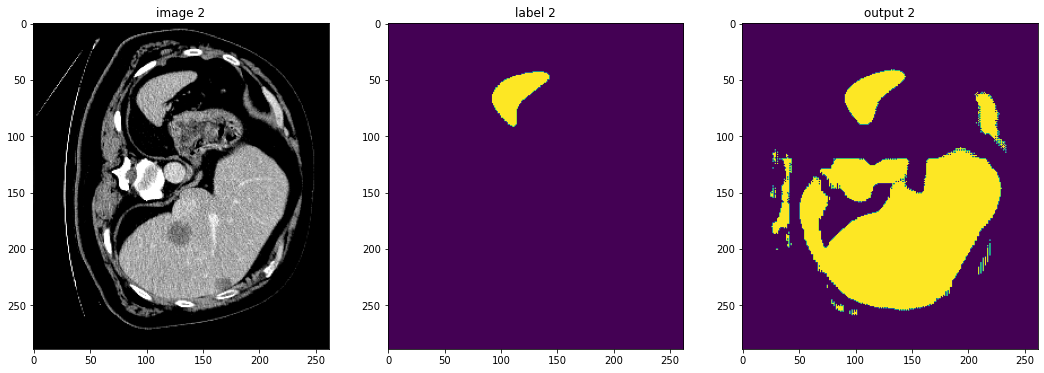

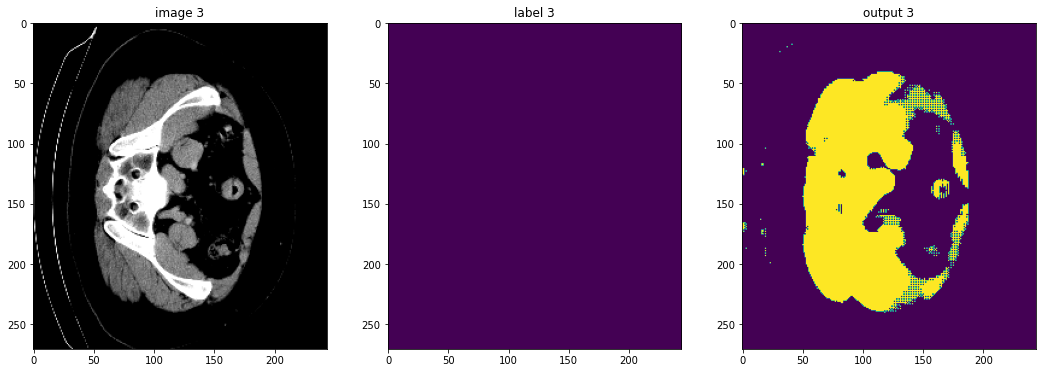

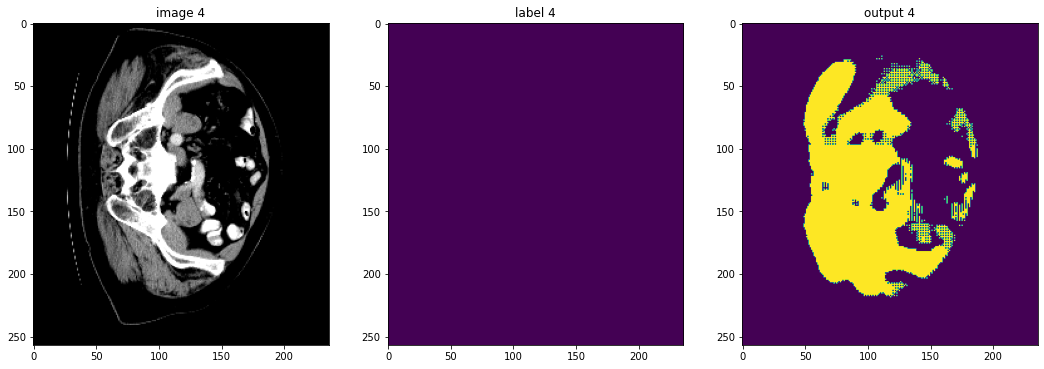

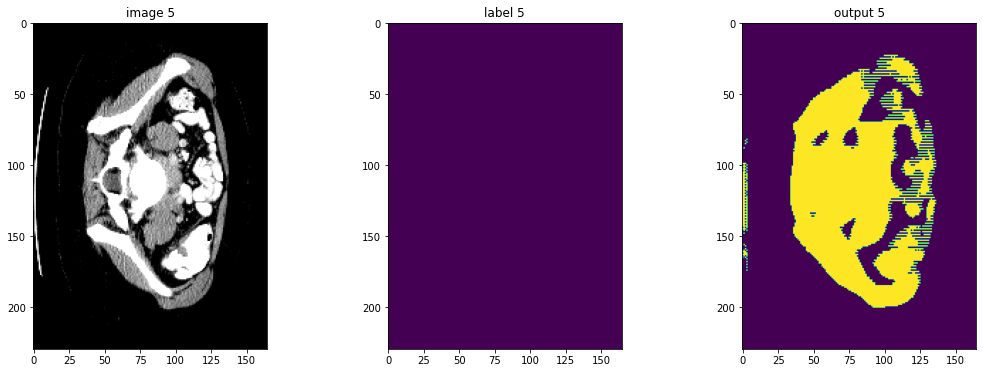

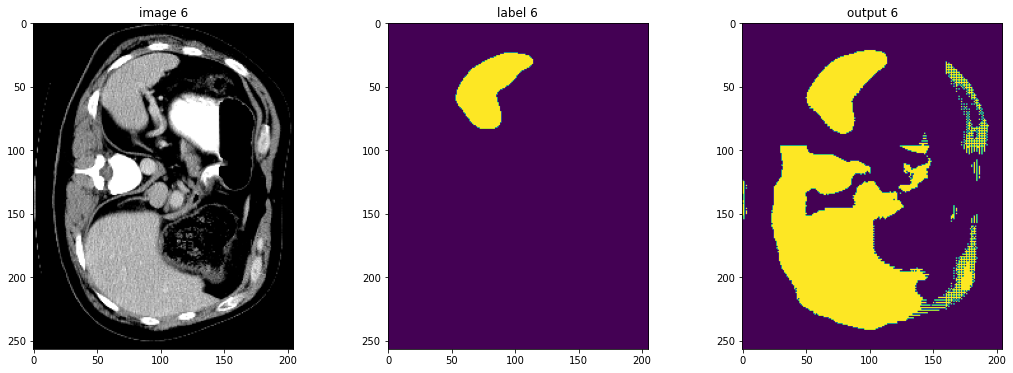

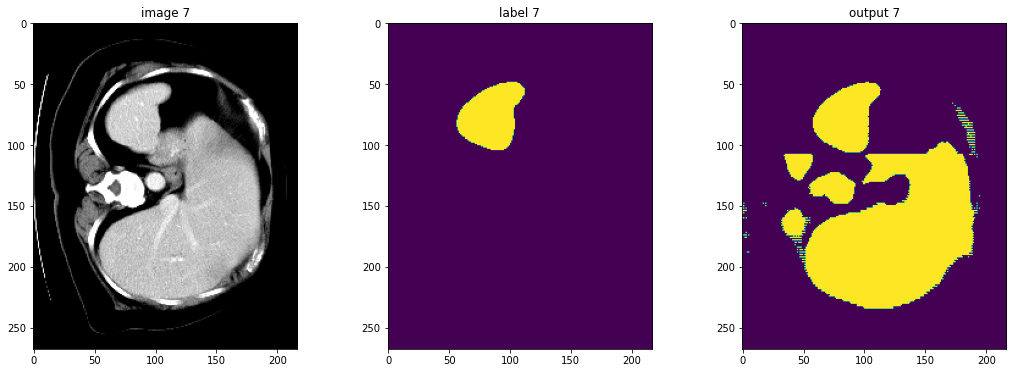

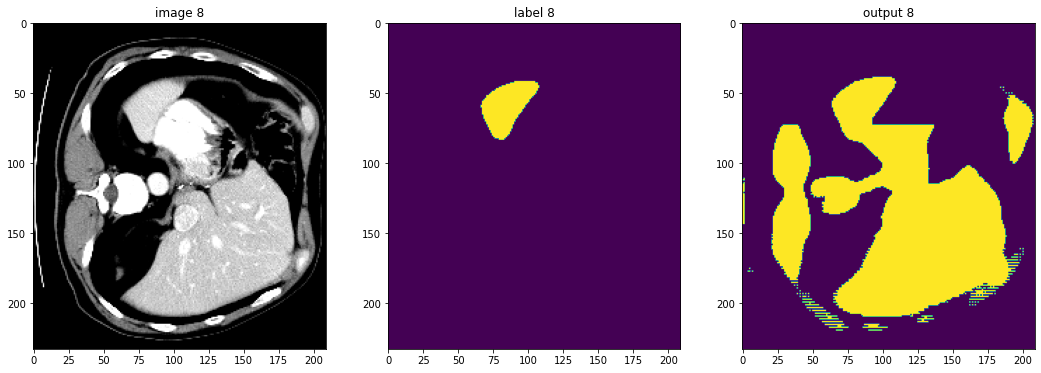

In [10]:
net.eval()
device = torch.device("cuda:0")
net.to(device)
with torch.no_grad():
    for i, val_data in enumerate(net.val_dataloader()):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, net
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()